#  Netflix Recommendations



## Control Flow

1. Load the data into a dataframe.
2. Remove outlier movies and users.
3. Gerate a training set (90% of users) and a test set (10% of users).
4. Cluster the training set according to a clustering algorithm.
5. Define the center of the cluster as the ranked list of movies.
6. Test phase for each clustering algorithm:
    i. For each user in the test set:
        I. Get their top 3 favorite movies.
        II. Assign them to a most likely cluster.
        III. Give them the ranked list of movies (defined by the cluster center in part 5) as recommendations.
    ii. Calculate precision, recall, and RMSE for the clustering method.
7. Make data visualizations for the clusters and performance.

### Importing libraries

In [162]:
import time
import pandas as pd
import numpy as np
import os
import math
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

### Control Flow Steps 1-2
The result of the computation will be a parquet file called `./Data/removedoutliersdf.parquet.gzip` of the dataframe which holds all of the ratings data with outlier movies and users removed.

To make this more efficient, we are only using the ratings data from `./Data/combined_data_1.txt`.

In [2]:
# Loading the ratings data and filtering out the outliers
if not os.path.isfile('./Data/removedoutliersdf.parquet.gzip'):
    # import the rating data as pandas dataframe
    df = pd.read_csv('./Data/combined_data_1.txt', header=None, names=['UserId', 'Rating'], usecols=[0, 1])

    df['Rating'] = df['Rating'].astype(float)  # Rating is temporarily a float

    df.index = np.arange(0, len(df))  # reindex the ratings

    # Adding the MovieId to the data frame
    df_nan = pd.DataFrame(pd.isnull(df.Rating))
    df_nan = df_nan[df_nan['Rating'] == True]
    df_nan = df_nan.reset_index()

    movie_np = []
    movie_id = 1

    for i, j in zip(df_nan['index'][1:], df_nan['index'][:-1]):
        # numpy approach
        temp = np.full((1, i-j-1), movie_id)
        movie_np = np.append(movie_np, temp)
        movie_id += 1

    last_record = np.full((1, len(df) - df_nan.iloc[-1, 0] - 1), movie_id)
    movie_np = np.append(movie_np, last_record)

    df = df[pd.notnull(df['Rating'])]

    df['MovieId'] = movie_np.astype(int)
    df['UserId'] = df['UserId'].astype(int)


    # Removing unpopular movies and users with too few reviews
    # Removing the 70% least popular movies and users with the least ratings
    f = ['count', 'mean']

    df_movie_summary = df.groupby('MovieId')['Rating'].agg(f)
    df_movie_summary.index = df_movie_summary.index.map(int)
    movie_benchmark = round(df_movie_summary['count'].quantile(0.7), 0)
    drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

    print('Movie minimum times of review: {}'.format(movie_benchmark))

    df_cust_summary = df.groupby('UserId')['Rating'].agg(f)
    df_cust_summary.index = df_cust_summary.index.map(int)
    cust_benchmark = round(df_cust_summary['count'].quantile(0.7), 0)
    drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

    print('Customer minimum times of review: {}'.format(cust_benchmark))

    print('Original Shape: {}'.format(df.shape))
    df = df[~df['MovieId'].isin(drop_movie_list)]
    df = df[~df['UserId'].isin(drop_cust_list)]

    df['Rating'] = df['Rating'].astype(int)

    print('After Trim Shape: {}'.format(df.shape))

    print(df.describe())

    df.to_parquet('./Data/removedoutliersdf.parquet.gzip', compression='gzip')


Here getting the list of movie titles minus the outliers that were filtered out from above.
The result is a parquet file titled `./Data/filteredmovietitlesdf.parquet.gzip` to regenerate the dataframe for later use, if needed.

In [3]:
# Get a list of movie titles that passed the above filter
if not os.path.isfile('./Data/filteredmovietitlesdf.parquet.gzip'):
    df = pd.read_parquet('./Data/removedoutliersdf.parquet.gzip')
    df_title = pd.read_csv('./Data/movie_titles.csv', encoding="ISO-8859-1", header=None, usecols=[0, 2],
                           names=['MovieId', 'Name'])
    # df_title.set_index('MovieId', inplace=True)
    df_title = pd.merge(df, df_title, how='inner', on='MovieId').drop_duplicates(subset=['MovieId'])[['MovieId', 'Name']]
    df_title.to_parquet('./Data/filteredmovietitlesdf.parquet.gzip', compression='gzip')

### Generating the training set
The result is a parquet file titled `./Data/trainingusersdf.parquet.gzip`.
This should be statistically similar to the removedoutliers dataset.

In [4]:
# Make a training set of users
if not os.path.isfile('./Data/trainingusersdf.parquet.gzip'):
    df = pd.read_parquet('./Data/removedoutliersdf.parquet.gzip')
    df2 = df.loc[df['UserId'] % 10 != 0]
    print("Original data set statistics:")
    print(df.describe())
    print("Training data set statistics:")
    print(df2.describe())
    df2.to_parquet('./Data/trainingusersdf.parquet.gzip', compression='gzip')

### Generating the test set
The result is a parquet file titled `./Data/testusersdf.parquet.gzip`.
This should be statistically similar to the removedoutliers dataset.

In [5]:
# Make a test set of users
if not os.path.isfile('./Data/testusersdf.parquet.gzip'):
    df = pd.read_parquet('./Data/removedoutliersdf.parquet.gzip')
    df2 = df.loc[df['UserId'] % 10 == 0]
    print("Original data set statistics:")
    print(df.describe())
    print("Test data set statistics:")
    print(df2.describe())
    df2.to_parquet('./Data/testusersdf.parquet.gzip', compression='gzip')


Pivoting the training data into a user-item matrix. 

In [6]:
# Pivot the data frame into a user-item matrix
df = pd.read_parquet('./Data/trainingusersdf.parquet.gzip')
df = pd.pivot_table(df, values='Rating', index='UserId', columns='MovieId', fill_value=0)
df.head(10)

MovieId,3,8,16,17,18,26,28,30,32,33,...,4472,4474,4478,4479,4485,4488,4490,4492,4493,4496
UserId,,,,,,,,,,,,,,,,,,,,,
6,0,0,0,0,0,0,0,3,0,0,...,3,0,0,0,0,0,0,0,0,0
7,0,5,0,0,0,0,4,5,0,0,...,3,0,0,5,0,0,0,0,0,0
79,0,0,0,0,0,0,0,3,0,0,...,4,0,0,0,0,0,4,0,0,0
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
134,0,0,0,0,0,0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
169,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
183,0,0,0,0,0,0,0,4,0,0,...,0,0,0,0,0,0,3,0,0,0
188,0,0,0,0,0,0,0,3,0,0,...,0,0,0,0,0,0,3,3,0,0
195,0,0,0,0,0,0,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0


In [7]:
# We need toknow the distribution of rating for scaling predicted movie ratings later
arr = df.to_numpy()
totalratings = (arr > 0).sum()
trainingdistribution = [(arr == i).sum() / totalratings for i in range(1,6)]
del(arr)
trainingdistribution  # trainingdistribution[n] is the percentage of (n + 1) star ratings

[0.041595441412623065,
 0.10133809041775821,
 0.299150173818603,
 0.3404211110594192,
 0.21749518329159656]

## Clustering

### kmeans

Below, we are using the elbow method to find an optimal number of clusters to use for kmeans. It takes about 2-3hrs to run, the result is the following figure:
![kmeansclusters](Figure_1.png)

The important DataFrames in this section are:

`dfkmeansclustercenters` - This is all of the cluster centers after kmeans. This also represents a ranked list of movies for the cluster, which is the recommendation list we givee to the new users in the test data when they fall close to this cluster center.

`dfkmeanslabels` - This is a table associating a UserId with a cluster number after kmeans.

`dfkmeans` This is the user-item DataFrame with an extra column associating each UserId with a cluster number.

In [8]:
# # Finding best number of clusters for kmeans This takes about 2-3hrs.
# model = KMeans()
# # k is range of number of clusters.
# visualizer = KElbowVisualizer(model, k=[(5 * i) + 2 for i in range(20)], timings=True)
# visualizer.fit(df)        # Fit data to visualizer
# visualizer.show()        # Finalize and render figure

In [9]:
# cluster df using kmeans
time_start = time.time()
kmeans = KMeans(n_clusters=22).fit(df)
print('Clustering with k-means took {} seconds'.format(time.time()-time_start))

Clustering with k-means took 323.8030207157135 seconds


In [10]:
# cluster centers after kmeans
# each cluster is a community of users who like the same movies. The center is our ranked list of movies for the cluster.
dfkmeansclustercenters = pd.DataFrame(kmeans.cluster_centers_, columns=df.columns)

In [11]:
# The cluster label given to a UserId
dfkmeanslabels = pd.DataFrame(kmeans.labels_)

In [12]:
# Reindexing the labels to be UserIds and renaming the column to "cluster_number"
dfkmeanslabels.index = df.index
dfkmeanslabels.columns = ["cluster_number"]

In [13]:
# dfkmeans is the user-item matrix with an extra column labeling which cluster the UserId belongs to after kmeans.
# The index are UserIds and columns are MovieIds + cluster_number
dfkmeans = df.join(dfkmeanslabels)
dfkmeans.head(10)

,3,8,16,17,18,26,28,30,32,33,...,4474,4478,4479,4485,4488,4490,4492,4493,4496,cluster_number
UserId,,,,,,,,,,,,,,,,,,,,,
6,0,0,0,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,16
7,0,5,0,0,0,0,4,5,0,0,...,0,0,5,0,0,0,0,0,0,19
79,0,0,0,0,0,0,0,3,0,0,...,0,0,0,0,0,4,0,0,0,3
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12
134,0,0,0,0,0,0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,21
169,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
183,0,0,0,0,0,0,0,4,0,0,...,0,0,0,0,0,3,0,0,0,0
188,0,0,0,0,0,0,0,3,0,0,...,0,0,0,0,0,3,3,0,0,6
195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,15


## Assigning new users to clusters per clustering algorithm

### Helper functions

In [14]:
# Get the 3 favorite movies from a test user. It is likely there is more than 3 tied. Get 3 random movies from those tied so that we aren't biased to the lower movieids.
def get3favoritemovies(testuserstransposed, user):
    return testuserstransposed.nlargest(3, user, keep='all')[user].sample(n=3)

In [15]:
# All of the different cluster center dataframes.
# The nth object in this list is a DataFrame for the nth clustering algorithm such that 
# the row indices is an index of a cluster center and the columns are movieids.
clustercenters = [dfkmeansclustercenters] 

# All of the classified test users for each cluster algorithm
# The nth object in this list is a DataFrame for the nth clustering algorithm. The rows in the DataFrame are test userids 
# and there is one column, which is the cluster number the test user belongs in.
classifiedtestusers = [] 

In [16]:
# loading the test user dataset into dftestusers
dftestusers = pd.read_parquet('./Data/testusersdf.parquet.gzip')
dftestusers = pd.pivot_table(dftestusers, values='Rating', index='UserId', columns='MovieId', fill_value=0)
dftestusers.head(10)

MovieId,3,8,16,17,18,26,28,30,32,33,...,4472,4474,4478,4479,4485,4488,4490,4492,4493,4496
UserId,,,,,,,,,,,,,,,,,,,,,
1070,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1310,0,0,0,0,0,0,3,3,0,0,...,0,0,0,4,0,0,3,0,0,5
1500,0,0,0,0,0,0,1,4,0,0,...,3,0,0,0,0,0,0,0,0,0
1830,0,0,0,0,0,0,5,5,0,0,...,2,0,0,0,0,0,0,0,0,0
1900,0,0,0,0,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000,0,0,0,0,3,0,4,0,0,0,...,5,0,0,5,0,4,0,0,0,4
2050,0,0,0,0,0,0,0,4,0,0,...,0,0,0,0,0,0,0,0,0,0
2250,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2270,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
testuserids = dftestusers.index # List of UserIds in the test set
testuserstransposed = dftestusers.T # Needs to be transposed to easily find 3 favorite movies
testuserstransposed.head(10)

UserId,1070,1310,1500,1830,1900,2000,2050,2250,2270,2280,...,2647690,2648260,2648290,2648730,2649050,2649080,2649100,2649110,2649120,2649370
MovieId,,,,,,,,,,,,,,,,,,,,,
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,0,0,0,0,0,3,0,0,0,0,...,0,0,0,0,3,0,0,0,0,0
26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28,0,3,1,5,4,4,0,0,0,0,...,0,0,4,4,0,0,5,0,0,0
30,0,3,4,5,0,0,4,0,0,0,...,0,4,3,3,4,0,0,3,1,0
32,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# HERE WE ARE LOOPING FOR EACH CLUSTER ALGORITHM
#    FOR EACH USER IN TEST SET
#        ASSIGN USER TO CLUSTER
#    STORE ALL TEST USER ASSIGNMENTS FOR THE CLUSTERING ALGORITHM

for algoindex in range(len(clustercenters)):  # for each clustering algorithm
    start_time = time.time()
    testuserclassifications = []  # this is a list of new users assigned to clusters
    for user in testuserids:  # for each userid in the test set
        favs = get3favoritemovies(testuserstransposed, user)  # get 3 favorite movies of the user
        clustermatrix = clustercenters[algoindex][favs.index].to_numpy()  # make numpy matrix where rows is the cluster_center_# and column is the 3 favorite movie ids
        dist = [np.linalg.norm(clustermatrix[i] - favs.to_numpy()) for i in range(len(clustermatrix))]  # calculate the distance of the user to each cluster center
        testuserclassifications.append(dist.index(min(dist)))  # classify the new user to the closest cluster center
    print('Assigning test users to a cluster using clustering algorithm {0} took {1} seconds'.format(algoindex, time.time()-start_time))
    dftestuserclassifications = pd.DataFrame(testuserclassifications, index=dftestusers.index, columns=["cluster_number"]) # make a dataframe with userids assigned to clusters
    classifiedtestusers.append(dftestuserclassifications) # add this assignment too classified test users list

Assigning test users to a cluster using clustering algorithm 0 took 1347.05393409729 seconds


In [19]:
classifiedtestusers[0].head(10)  # These are the first 10 test users and which kmeans cluster they belong in 

,cluster_number
UserId,
1070,8
1310,11
1500,13
1830,11
1900,11
2000,2
2050,11
2250,2
2270,2


### Building movie rating prediction DataFrames

In [20]:
# The nth value in the list is a DataFrame corresponding to the nth clustering algorithm 
# where the rows a test userids and the columns are movieids 
# and the values of the DataFrame are predicted movie ratings
predictions = []  

In [21]:
for algonumber in range(len(clustercenters)):
    dftestuserpredictions = pd.DataFrame(columns=dftestusers.columns) # set up the test user predictions DataFrame
    start_time = time.time()
    for index, row in classifiedtestusers[algonumber].iterrows(): # for each classified test user
        # Give the user the same recommendations as their assigned cluster. This will be the cluster center point.
        dftestuserpredictions.loc[index] = clustercenters[algonumber].loc[row["cluster_number"]]
    print('Giving test users recommendations for clustering algorithm {0} took {1} seconds'.format(algoindex, time.time()-start_time))
    predictions.append(dftestuserpredictions)

Giving test users recommendations for clustering algorithm 0 took 378.18175172805786 seconds


In [22]:
# The prediction rating distribution needs to be rescaled to match the distribution 
# of the training set found above, which is the array "trainingdistribution"
for dfpredicition in predictions:
        nparr = dfpredicition.to_numpy() # its easier to do part this in numpy
        
        # get the cutoffs for the n-th star rating
        quantilevalues = [np.quantile(nparr, sum(trainingdistribution[0:i]), axis=None) for i in range(1,5)]
        
        # revalue the predicted movie ratings
        nparr[nparr >= quantilevalues[3]] = 5 # Rescale the 5-star predictions
        nparr[(nparr >= quantilevalues[2]) & (nparr < quantilevalues[3])] = 4 # Rescale the 4-star predictions
        nparr[(nparr >= quantilevalues[1]) & (nparr < quantilevalues[2])] = 3 # Rescale the 3-star predictions
        nparr[(nparr >= quantilevalues[0]) & (nparr < quantilevalues[1])] = 2 # Rescale the 2-star predictions
        nparr[(nparr >= 0) & (nparr < quantilevalues[0])] = 1 # Rescale the 1-star predictions
        
        # replace the predictions dataframe with the dataframe version of nparr, 
        # which is the correctly scaled predictions
        dfpredictions = pd.DataFrame(nparr, dfpredicition.index, columns=dfpredicition.columns)  

In [23]:
# This is the first 10 test users and their predicted movie rating preferences for kmeans (the 0th clustering algorithm)
predictions[0].head(10) 

MovieId,3,8,16,17,18,26,28,30,32,33,...,4472,4474,4478,4479,4485,4488,4490,4492,4493,4496
1070,1.0,3.0,3.0,2.0,4.0,2.0,4.0,5.0,1.0,4.0,...,5.0,4.0,2.0,3.0,3.0,4.0,3.0,4.0,3.0,3.0
1310,2.0,3.0,4.0,3.0,4.0,4.0,5.0,5.0,3.0,3.0,...,5.0,4.0,2.0,4.0,4.0,5.0,4.0,4.0,3.0,3.0
1500,1.0,2.0,2.0,3.0,3.0,3.0,5.0,5.0,3.0,2.0,...,5.0,3.0,1.0,4.0,2.0,4.0,3.0,3.0,3.0,2.0
1830,2.0,3.0,4.0,3.0,4.0,4.0,5.0,5.0,3.0,3.0,...,5.0,4.0,2.0,4.0,4.0,5.0,4.0,4.0,3.0,3.0
1900,2.0,3.0,4.0,3.0,4.0,4.0,5.0,5.0,3.0,3.0,...,5.0,4.0,2.0,4.0,4.0,5.0,4.0,4.0,3.0,3.0
2000,3.0,4.0,3.0,1.0,5.0,2.0,4.0,5.0,1.0,3.0,...,5.0,3.0,4.0,5.0,4.0,5.0,3.0,2.0,3.0,5.0
2050,2.0,3.0,4.0,3.0,4.0,4.0,5.0,5.0,3.0,3.0,...,5.0,4.0,2.0,4.0,4.0,5.0,4.0,4.0,3.0,3.0
2250,3.0,4.0,3.0,1.0,5.0,2.0,4.0,5.0,1.0,3.0,...,5.0,3.0,4.0,5.0,4.0,5.0,3.0,2.0,3.0,5.0
2270,3.0,4.0,3.0,1.0,5.0,2.0,4.0,5.0,1.0,3.0,...,5.0,3.0,4.0,5.0,4.0,5.0,3.0,2.0,3.0,5.0
2280,2.0,3.0,4.0,3.0,4.0,4.0,5.0,5.0,3.0,3.0,...,5.0,4.0,2.0,4.0,4.0,5.0,4.0,4.0,3.0,3.0


## Calculating RMSE/Precision/Recall for the different recommender systems

In [26]:
# We need to replace the predicted movie rating with a 0 where the true rating does not exist
# to avoid adding more error than supposed to
for index in range(len(predictions)):
    predictions[index] = dftestusers.where(dftestusers == 0, predictions[index])
predictions[0].head(10)

MovieId,3,8,16,17,18,26,28,30,32,33,...,4472,4474,4478,4479,4485,4488,4490,4492,4493,4496
UserId,,,,,,,,,,,,,,,,,,,,,
1070,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1310,0,0,0,0,0,0,5,5,0,0,...,0,0,0,4,0,0,4,0,0,3
1500,0,0,0,0,0,0,5,5,0,0,...,5,0,0,0,0,0,0,0,0,0
1830,0,0,0,0,0,0,5,5,0,0,...,5,0,0,0,0,0,0,0,0,0
1900,0,0,0,0,0,0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000,0,0,0,0,5,0,4,0,0,0,...,5,0,0,5,0,5,0,0,0,5
2050,0,0,0,0,0,0,0,5,0,0,...,0,0,0,0,0,0,0,0,0,0
2250,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2270,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [105]:
# RMSE (we cant use the sklearn function with missing true data)
nptestusers = dftestusers.to_numpy()  # Easier with numpy. This is the true user-item matrix of test users.
for index in range(len(predictions)):  # Calculate rmse for each recommender system
    nppredictions = predictions[index].to_numpy() # Easier with numpy. This is the predicted user-item matrix of test users on cluster algo #index.
    sse = 0 # sum of squared error
    for row in range(nptestusers.shape[0]):
        for col in range(nptestusers.shape[1]):
            if nptestusers[row, col] != 0:  # if there is no data on test user rating movie, then skip
                sse += (nptestusers[row, col] - nppredictions[row, col]) ** 2  # add the squared error
    rmse = math.sqrt(sse * (1 / np.count_nonzero(nptestusers)))  # divide by the total number of predictions, then sqrt.
    print('RMSE for clustering algorithm {0}: {1}'.format(index, rmse))

RMSE for clustering algorithm 0: 1.5197703525414996


In [106]:
# get the top k movieids from userid in the DataFrame df. If there is a tie, choose those randomly.
def getTopK(df, k, userid):
    dftopk = df.T.nlargest(k, columns=userid)
    smallestrating = dftopk[userid].min()  # Get smallest rating from userid in top k
    smallestratingoccurences = dftopk.loc[dftopk[userid] == smallestrating].shape[0]  # count how many of the smallest ratings occur
    dftopk = dftopk.loc[dftopk[userid] > smallestrating]  # keep all of the ratings above the smallest
    # add a total of "smallestratingoccurences" rows to dftopk from df.T whose value is smallestrating at random
    randomrows = df.T.loc[df.T[userid] == smallestrating].sample(smallestratingoccurences)
    dftopk = pd.concat([dftopk, randomrows])
    if dftopk.shape[0] != k and smallestrating > 2:  # if there is a bug, this will help
        print('Something is wrong with top {0} and userid {1}'.format(k, userid))
    return dftopk.loc[dftopk[userid] > 2].index # only return the top 50, or less if we remove 1-2 star ratings

In [107]:
# recommended movies are the list of top k recommended movieids, or less if there are 1-2 stars in top k
# truemovies are all the true movieids with 3+ star ratings from the user
def precisionAtK(recommendedmovies, truemovies):
    # intersect the lists and count number of movies
    totalrecommendedrelevantmovies = len(set(recommendedmovies).intersection(truemovies))
    totalrecommendedmovies = len(recommendedmovies)
    return totalrecommendedrelevantmovies / totalrecommendedmovies

In [111]:
def recallAtK(recommendedmovies, truemovies):
    # intersect the lists and count number of movies
    totalrecommendedrelevantmovies = len(set(recommendedmovies).intersection(truemovies))
    totalrelevantmovies = len(truemovies)
    if totalrelevantmovies > 0:
        return totalrecommendedrelevantmovies / totalrelevantmovies
    else:
        return 0

In [112]:
# The Nth value in these arrays is array of precisions at top 50 recommendations for the Nth recommender system, and the recalls at top 50.
precisionat50 = [] 
recallat50 = []

In [113]:
# Takes about 30min
for algonumber in range(len(predictions)):
    precision = []
    recall = []
    for index, row in predictions[algonumber].iterrows():
        # Get the recommended top 50 movieids for userid == index, or less if there are 1-2 star predictions in top 50
        recommendedTop50Movies = getTopK(predictions[algonumber], 50, index)
        true3PlusStarMovies = dftestusers.T.loc[dftestusers.T[index] >= 3].index
        precision.append(precisionAtK(recommendedTop50Movies, true3PlusStarMovies))
        recall.append(recallAtK(recommendedTop50Movies, true3PlusStarMovies))
    precisionat50.append(precision)
    recallat50.append(recall)

## Data Visualization Section

No handles with labels found to put in legend.


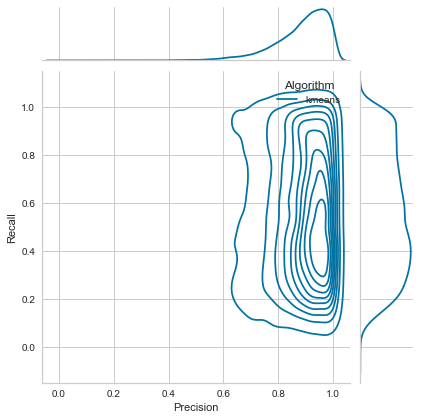

In [167]:
prmatrix = np.asarray([precisionat50[0], recallat50[0], ["kmeans" for i in range(dftestusers.shape[0])]])
prmatrix = np.transpose(prmatrix)
dfpr = pd.DataFrame(prmatrix, index=dftestusers.index, columns=['Precision', 'Recall', 'Algorithm'])
dfpr = pd.concat((dfpr[['Precision', 'Recall']].apply(pd.to_numeric), dfpr['Algorithm'].astype(str)), axis=1)
sns.jointplot(x="Precision", y="Recall", kind="kde", hue="Algorithm", data=dfpr)
plt.legend(bbox_to_anchor=(1.01,1), borderaxespad=0)